# Week 3 Project

This notebook demonstrates the implementation of a Q-learning agent in a GridWorld environment using OpenAI Gym. The agent learns to navigate a grid, avoiding mines and aiming for the goal.


IMPORTS

In [20]:
import gym
from gym import spaces
import numpy as np
import random
import pygame
import time
import random
import matplotlib.pyplot as plt
import pygame
import seaborn as sns

## Environment Setup
The GridWorld environment is defined as a 10x10 grid with mines and special spots. The agent starts at the origin and aims to reach the goal at the opposite corner. The agent can move up,dow,right and left. For every step agent gets a -1 reward except when it goes on special spots where it gets -0.5 and 0 on reaching the destination
We will define the environment class `GridWorldEnv`.


In [29]:
class GridWorldEnv(gym.Env):
    def __init__(self):
        super(GridWorldEnv, self).__init__()
        self.grid_size = 10
        self.state = None
        self.mines = None
        self.special_spots = None

        self.action_space = spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size),
            spaces.Discrete(self.grid_size)
        ))

        # Set random seed for reproducibility
        self.seed()

    def seed(self, seed=None):
        random.seed(seed)
        np.random.seed(seed)

    def reset(self):
        self.state = [0, 0]
        self.mines = self._generate_mines(5)
        self.special_spots = self._generate_special_spots(5)
        return tuple(self.state)

    def step(self, action):
        x, y = self.state

        if action == 0:  # Up
            y = max(y - 1, 0)
        elif action == 1:  # Down
            y = min(y + 1, self.grid_size - 1)
        elif action == 2:  # Left
            x = max(x - 1, 0)
        elif action == 3:  # Right
            x = min(x + 1, self.grid_size - 1)

        # Ensure the agent moves
        if (x, y) == tuple(self.state):
            action = random.choice([0, 1, 2, 3])
            return self.step(action)

        self.state = [x, y]
        reward, done = self._get_reward_and_done()
        return tuple(self.state), reward, done, {}

    def _generate_mines(self, count):
        mines = set()
        while len(mines) < count:
            mine = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if mine != (0, 0) and mine != (self.grid_size - 1, self.grid_size - 1):
                mines.add(mine)
        return mines

    def _generate_special_spots(self, count):
        spots = set()
        while len(spots) < count:
            spot = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if spot != (0, 0) and spot != (self.grid_size - 1, self.grid_size - 1) and spot not in self.mines:
                spots.add(spot)
        return spots

    def _get_reward_and_done(self):
        x, y = self.state
        if (x, y) in self.mines:
            return -1, True
        if (x, y) == (self.grid_size - 1, self.grid_size - 1):
            return 0, True
        if (x, y) in self.special_spots:
            return -0.5, False
        return -1, False

    def render(self, mode='human'):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:] = '.'
        for mine in self.mines:
            grid[mine] = 'M'
        for spot in self.special_spots:
            grid[spot] = 'S'
        grid[self.state[1], self.state[0]] = 'A'
        grid[self.grid_size - 1, self.grid_size - 1] = 'G'
        for row in grid:
            print(' '.join(row))
        print()


## Taking random actions

In [31]:
class EpsilonGreedyAgent:
    def __init__(self, action_space, epsilon=0.1):
        self.action_space = action_space
        self.epsilon = epsilon

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.action_space.sample() 
        else:
            return np.random.choice([0, 1, 2, 3]) 

env = GridWorldEnv()
agent = EpsilonGreedyAgent(env.action_space, epsilon=0.1)

state = env.reset()
env.render()

for _ in range(20):  
    action = agent.select_action(state)
    state, reward, done, _ = env.step(action)
    env.render()
    if done:
        break


A . . . . . . . M .
S . . . . . . . . .
. . . . . . . . . .
. . . . . S . . . .
S . . . S . . . S .
M . . . . . . . . .
. . . . . . M . . .
. . . . . . . . . .
. . . . . . . . . M
. . . . M . . . . G

. . . . . . . . M .
A . . . . . . . . .
. . . . . . . . . .
. . . . . S . . . .
S . . . S . . . S .
M . . . . . . . . .
. . . . . . M . . .
. . . . . . . . . .
. . . . . . . . . M
. . . . M . . . . G

. . . . . . . . M .
S . . . . . . . . .
A . . . . . . . . .
. . . . . S . . . .
S . . . S . . . S .
M . . . . . . . . .
. . . . . . M . . .
. . . . . . . . . .
. . . . . . . . . M
. . . . M . . . . G

. . . . . . . . M .
A . . . . . . . . .
. . . . . . . . . .
. . . . . S . . . .
S . . . S . . . S .
M . . . . . . . . .
. . . . . . M . . .
. . . . . . . . . .
. . . . . . . . . M
. . . . M . . . . G

. . . . . . . . M .
S . . . . . . . . .
A . . . . . . . . .
. . . . . S . . . .
S . . . S . . . S .
M . . . . . . . . .
. . . . . . M . . .
. . . . . . . . . .
. . . . . . . . . M
. . . . M . . . 

## Agent Implementation
Implement a Q-learning agent that interacts with the `GridWorldEnv` to learn an optimal policy. 



In [32]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1):
        self.env = env
        self.q_table = np.zeros((env.grid_size, env.grid_size, env.action_space.n))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Explore
        return np.argmax(self.q_table[state[0], state[1]])  # Exploit

    def update_q_values(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state[0], next_state[1]])
        td_target = reward + self.discount_factor * self.q_table[next_state[0], next_state[1], best_next_action]
        td_error = td_target - self.q_table[state[0], state[1], action]
        self.q_table[state[0], state[1], action] += self.learning_rate * td_error

    def train(self, num_episodes):
        rewards = []
        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            done = False

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q_values(state, action, reward, next_state)
                state = next_state
                total_reward += reward

            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            rewards.append(total_reward)

        return rewards, episode + 1


## Training the Agent


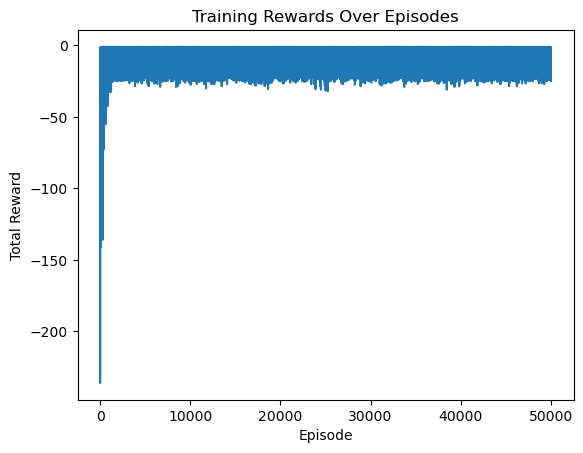

Training completed in 50000 episodes.


In [33]:
env = GridWorldEnv()
agent = QLearningAgent(env, learning_rate=0.2, discount_factor=0.95, epsilon=0.4)

max_episodes = 50000
rewards, trained_episodes = agent.train(max_episodes)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards Over Episodes')
plt.show()

print(f"Training completed in {trained_episodes} episodes.")


## Simulation of the Trained Agent


In [35]:
def simulate(env, agent):
    pygame.init()
    screen = pygame.display.set_mode((400, 400))
    pygame.display.set_caption("GridWorld Simulation")
    block_size = 40  

    colors = {
        "agent": (0, 255, 0),     # Green
        "goal": (255, 255, 0),    # Yellow
        "mine": (255, 0, 0),      # Red
        "special_spot": (0, 0, 255), # Blue
        "empty": (200, 200, 200)    # Light Gray
    }

    def draw_grid(state):
        for y in range(env.grid_size):
            for x in range(env.grid_size):
                rect = pygame.Rect(x * block_size, y * block_size, block_size, block_size)
                if (x, y) == tuple(state):
                    pygame.draw.rect(screen, colors["agent"], rect)
                elif (x, y) == (env.grid_size - 1, env.grid_size - 1):
                    pygame.draw.rect(screen, colors["goal"], rect)
                elif (x, y) in env.mines:
                    pygame.draw.rect(screen, colors["mine"], rect)
                elif (x, y) in env.special_spots:
                    pygame.draw.rect(screen, colors["special_spot"], rect)
                else:
                    pygame.draw.rect(screen, colors["empty"], rect)
                pygame.draw.rect(screen, (0, 0, 0), rect, 1)  

    state = env.reset()
    done = False
    while not done:
        screen.fill((255, 255, 255)) 
        draw_grid(state)
        pygame.display.flip()
        time.sleep(0.5) 

        action = agent.select_action(state)
        state, reward, done, _ = env.step(action)

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True

    pygame.quit()
    print(f"Total Reward: {reward}")

simulate(env, agent)


Total Reward: -1



### Heatmap of Q-values


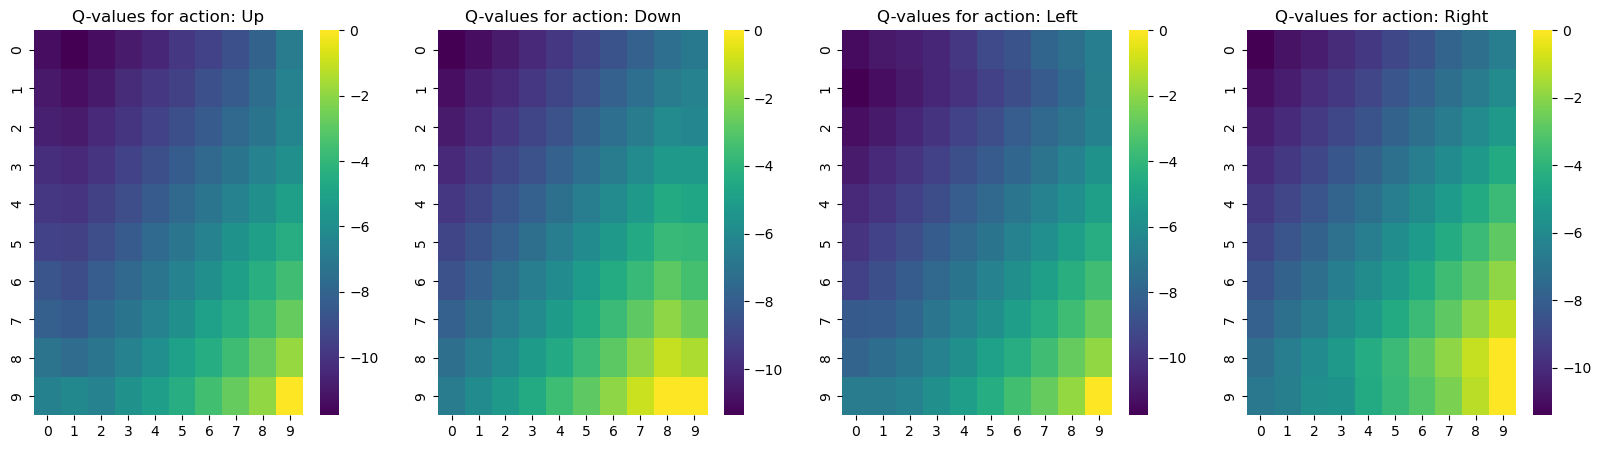

In [36]:
import seaborn as sns

def plot_q_values(agent):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    actions = ['Up', 'Down', 'Left', 'Right']
    for i, action in enumerate(actions):
        q_values = agent.q_table[:, :, i]
        sns.heatmap(q_values, ax=axes[i], cmap='viridis')
        axes[i].set_title(f'Q-values for action: {action}')
    plt.show()

plot_q_values(agent)


### Policy Visualization
Visualization of the policy derived from the Q-values, indicating the preferred action at each state.


In [37]:
def plot_policy(agent):
    grid = np.zeros((agent.env.grid_size, agent.env.grid_size), dtype=str)
    policy = np.argmax(agent.q_table, axis=2)

    for y in range(agent.env.grid_size):
        for x in range(agent.env.grid_size):
            if policy[x, y] == 0:
                grid[x, y] = '↑'
            elif policy[x, y] == 1:
                grid[x, y] = '↓'
            elif policy[x, y] == 2:
                grid[x, y] = '←'
            elif policy[x, y] == 3:
                grid[x, y] = '→'

    print("Learned Policy:")
    for row in grid:
        print(" ".join(row))

plot_policy(agent)


Learned Policy:
↓ → → → → → → → → →
↓ ↓ → → ↓ → → → → →
↓ ↓ → → ↓ ↓ → → ↓ →
→ ↓ ↓ → → → → ↓ → →
→ ↓ ↓ → ↓ → → → ↓ →
↓ ↓ → → ↓ → → → → →
→ → ↓ → → ↓ ↓ → → →
↓ → ↓ → ↓ ↓ ↓ → → →
↓ ↓ ↓ ↓ → → → → → →
↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↑
